### **Download and unzip data** 

In [1]:
!wget https://www.dropbox.com/s/455hyl1dks05lqk/mask_data.zip
!unzip -o mask_data.zip

--2021-04-16 14:58:21--  https://www.dropbox.com/s/455hyl1dks05lqk/mask_data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/455hyl1dks05lqk/mask_data.zip [following]
--2021-04-16 14:58:21--  https://www.dropbox.com/s/raw/455hyl1dks05lqk/mask_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf21f2a66c7bdad4cf28d1e3664.dl.dropboxusercontent.com/cd/0/inline/BMu_jDvZCRA5jtajscvfrCiL4ztF550T8ALDlvYCraaiG0Xy9JOWvaxJesTgYHLe6alCXEgZbdnvwKtkNJfsfT61Xf9bBF9GKPDf6Dis9kkOnbiBjfEv81FaNHm-deUiaIJyaM33zViQ3-bm3Qu7tAVp/file# [following]
--2021-04-16 14:58:21--  https://ucf21f2a66c7bdad4cf28d1e3664.dl.dropboxusercontent.com/cd/0/inline/BMu_jDvZCRA5jtajscvfrCiL4ztF550T8ALDlvYCraaiG0Xy9JOWvaxJesTgYHLe6alCXEgZbdnvwKtkNJfsfT6

# Import and view image

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os
import os
import xml.etree.ElementTree as ET
import cv2
!pip install xmltodict
import xmltodict, json
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cpu


Here have 853 images, and 853 xml files
['maksssksksss592.png', 'maksssksksss624.png', 'maksssksksss114.png', 'maksssksksss320.png', 'maksssksksss530.png', 'maksssksksss78.png', 'maksssksksss417.png', 'maksssksksss581.png', 'maksssksksss387.png', 'maksssksksss584.png', 'maksssksksss781.png', 'maksssksksss290.png', 'maksssksksss686.png', 'maksssksksss256.png', 'maksssksksss595.png', 'maksssksksss204.png', 'maksssksksss35.png', 'maksssksksss797.png', 'maksssksksss179.png', 'maksssksksss612.png', 'maksssksksss565.png', 'maksssksksss362.png', 'maksssksksss403.png', 'maksssksksss93.png', 'maksssksksss230.png', 'maksssksksss395.png', 'maksssksksss637.png', 'maksssksksss821.png', 'maksssksksss749.png', 'maksssksksss72.png', 'maksssksksss780.png', 'maksssksksss566.png', 'maksssksksss451.png', 'maksssksksss742.png', 'maksssksksss522.png', 'maksssksksss464.png', 'maksssksksss270.png', 'maksssksksss351.png', 'maksssksksss404.png', 'maksssksksss171.png', 'maksssksksss753.png', 'maksssksksss318.png

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


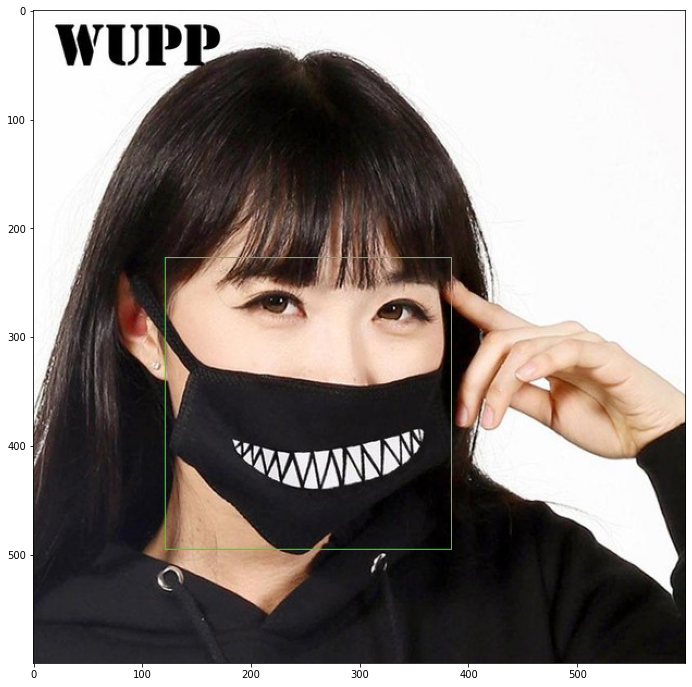

In [3]:
def xml_reader(img_dir, xml_dir):

  # create return array
  bndbox = []
  obj_name = []

  #first path join img directory and xml directory
  #from step two we can see image directory save as .png, xml directory save as .xml
  #here to join them we need to remove last three character from image directory and add xml to match 
  print(img_dir)            # /content/annotations
  print(img_dir[:-3])       # tensor([], device='cuda:0', size=(0, 366, 512))
  print(type(img_dir[:-3])) # <class 'torch.Tensor'>
  join_path = os.path.join(xml_dir, img_dir[:-3]+'xml')

  #find the root of the xml tree
  root = ET.parse(join_path).getroot()

  #write a loop to find all face boxes inside a xml file
  #both obj_name and bndbox data are under annotation - object 
  for face_box in root.iter('object'):
    #find xmin, ymin, xmax, ymax
    xmin = int(face_box.find("bndbox/xmin").text)
    ymin = int(face_box.find("bndbox/ymin").text)
    xmax = int(face_box.find("bndbox/xmax").text)
    ymax = int(face_box.find("bndbox/ymax").text)
    #append them into bndbox[]
    bndbox.append([xmin, ymin, xmax, ymax])

    #find name (with_mask, mask_weared_incorrect, without_mask)
    name = face_box.find('name').text
    #due to we do not want with_mask, mask_weared_incorrect, without_mask
    #so we trans them to 1 => with_mask, 2 => mask_weared_incorrect, 3 => without_mask
    if name == 'with_mask':
      obj_name.append(1)
    elif name == 'mask_weared_incorrect':
      obj_name.append(2)
    else:
      obj_name.append(3)

  #return bndbox and obj_name
  return bndbox, obj_name

def draw_box(image, bndbox, obj_name):
  
  #Convert BGR and RGB with OpenCV function
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

  #Use OpenCV add rectangle
  for box, name in zip(bndbox, obj_name):
    #box is a len 4 array
    box = [int(x) for x in box]
    #set the block green for with_mask, yellow for mask_weared_incorrect, red for without_mask
    #here is BGR value
    if name == 1:
      color = (0, 255, 0) #green
    elif name == 2:
      color = (0, 255, 255) #yellow
    elif name == 3:
      color = (0, 0, 255) #red
    #draw the rectangle
    cv2.rectangle(image, (box[0],box[1]),(box[2],box[3]),color,1)

  #return new image
  return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


  
img_path = '/content/images'
xml_path = '/content/annotations'
img_list = os.listdir(img_path);
xml_list = os.listdir(xml_path);

#print the number of image and xml files
print('Here have ' + format(len(img_list)) + ' images, and ' + format(len(xml_list)) + ' xml files')

#print image name
print (img_list)

#print xml name
print (xml_list)


# Get image randomly in the list
img0 = img_list[0]
print('Random image is: ' + img0)

#get bndbox and obj_name
bndbox, obj_name = xml_reader(img0, xml_path)
print('bndbox: ' + format(bndbox))
print('obj_name: ' + format(obj_name))

#use openCV draw box
image_with_box = draw_box(plt.imread(os.path.join(img_path,img0)), bndbox, obj_name)

#plot the image
plt.figure(figsize=(12,12))
plt.imshow(image_with_box)


# split train test

In [4]:
# create a list of all json anotaions
masks = []
for xml in xml_list:
  with open(os.path.join(xml_path,xml)) as fd:
    doc = fd.read()
    masks.append(json.dumps(xmltodict.parse(doc)))
train_mask, val_mask = train_test_split(masks, test_size=0.1)



def formated(label):
  category_idx = categories.index(label['name'])
  xmin, ymin = int(label['bndbox']['xmin']), int(label['bndbox']['ymin'])
  xmax, ymax = int(label['bndbox']['xmax']), int(label['bndbox']['ymax'])
  return category_idx, xmin, ymin, xmax, ymax

def create_dataset(images, categories, group):
  # prepare anotation and images 
  images_path = Path(f"masks/images/{group}")
  images_path.mkdir(parents=True, exist_ok=True)
  labels_path = Path(f"masks/labels/{group}")
  labels_path.mkdir(parents=True, exist_ok=True)

  for img_id, row in enumerate(tqdm(images)):
    image_name = f"{img_id}.jpeg"
    row = json.loads(row)
    image_file_name = row["annotation"]["filename"]
    
    label_name = f"{img_id}.txt"
    kinds = []
    if isinstance(row["annotation"]["object"], list):
      for name in row["annotation"]["object"]:
        kinds.append(name['name'])
    else: 
      kinds.append(row["annotation"]["object"]['name'])

    if 'without_mask' in kinds:
      with (labels_path / label_name).open(mode="w") as label_file:
        a = row["annotation"]
        if isinstance(a['object'], list):
          for label in a['object']:
            category_idx, xmin,ymin,xmax,ymax=formated(label)
            if category_idx==1:
              label_file.write(
              f"{category_idx} {xmin} {ymin} {xmax} {ymax}\n")
        else:
            category_idx, xmin,ymin,xmax,ymax=formated(a['object'])
            if category_idx==1:
              label_file.write(
              f"{category_idx} {xmin} {ymin} {xmax} {ymax}\n")

      img =  os.path.join(img_path,image_file_name)
      img = Image.open(img)
      img = img.convert("RGB")
      img.save(str(images_path / image_name), "JPEG")

categories = ['mask_weared_incorrect','without_mask','with_mask']
create_dataset(train_mask, categories, 'train')
create_dataset(val_mask, categories, 'val')

100%|██████████| 86/86 [00:00<00:00, 107.21it/s]


# Extract region: Selective search

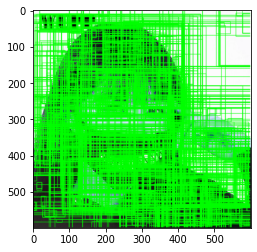

In [5]:
import os,cv2
import pandas as pd
import numpy as np
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
im = cv2.imread(os.path.join(img_path,img0))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

## calculate IoU function

In [6]:
# calculate IoU function
def get_iou(box1, box2):
    assert box1['x1'] < box1['x2']
    assert box1['y1'] < box1['y2']
    assert box2['x1'] < box2['x2']
    assert box2['y1'] < box2['y2']
    x_left = max(box1['x1'], box2['x1'])
    y_top = max(box1['y1'], box2['y1'])
    x_right = min(box1['x2'], box2['x2'])
    y_bottom = min(box1['y2'], box2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1['x2'] - box1['x1']) * (box1['y2'] - box1['y1'])
    box2_area = (box2['x2'] - box2['x1']) * (box2['y2'] - box2['y1'])
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Set postive(without mask) and negative(other) labels,  selective search

In [ ]:
def label_img(train_images,train_labels, timage, label, counter):
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    train_images.append(resized)
    train_labels.append(1)
    counter += 1
    return counter, train_labels, train_images

train_images=[]
train_labels=[]
annot = '/content/masks/labels/train'
imgs = '/content/masks/images/train'
for i,anno_name in enumerate(os.listdir(annot)):
  # the RAM will ran out after 200ish images, stop process at 170
  if i >170:
    break
  filename = anno_name.split(".")[0]+".jpeg"

  # get ground truth
  if os.stat(os.path.join(annot,anno_name)).st_size != 0:
    print(i,filename,"------------------")
    image = cv2.imread(os.path.join(imgs,filename))
    ground_truth_values=[]
    with open(os.path.join(annot,anno_name)) as fp:
      while True:
          line = fp.readline()
          if not line:
              break
          line = line.strip()
          items = line.split(" ")
          label = int(items[0])
          x1 = int(items[1])
          y1 = int(items[2])
          x2 = int(items[3])
          y2 = int(items[4])
          ground_truth_values.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

    # selecive search setting
    ss.setBaseImage(image)  
    ss.switchToSelectiveSearchFast()    
    squares = ss.process()
    img_cp = image.copy()
    counter = 0
    falsecounter = 0
    flag = 0
    positive_flag = 0
    negative_flag = 0

    # selective search
    for j,square in enumerate(squares):
        if j < 1000:     # get first 1000 features
            for gtval in ground_truth_values:
                x,y,w,h = square
                iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h}) 
                # 40 positive(without mask lable)
                if counter < 40:       
                    if iou > 0.70: 
                        sub_img = img_cp[y:y+h, x:x+w]
                        counter, train_labels, train_images = label_img(train_images,train_labels, sub_img, label, counter)
                else :
                    positive_flag =1     
                # 40 negative(other)       
                if falsecounter <40:    
                    if iou < 0.3:     
                        sub_img = img_cp[y:y+h, x:x+w]
                        counter, train_labels, train_images = label_img(train_images,train_labels, sub_img, label, falsecounter)
                else :
                    negative_flag = 1
            if positive_flag == 1 and negative_flag == 1:  
              # the data extraction for this image is done, move to next image
              continue
X_new = np.array(train_images)
Y_new = np.array(train_labels)

0 218.jpeg ------------------
1 722.jpeg ------------------
2 611.jpeg ------------------
3 466.jpeg ------------------
4 315.jpeg ------------------
5 596.jpeg ------------------
6 707.jpeg ------------------
7 81.jpeg ------------------
8 12.jpeg ------------------
9 358.jpeg ------------------
10 684.jpeg ------------------
11 640.jpeg ------------------
12 199.jpeg ------------------
13 271.jpeg ------------------
14 758.jpeg ------------------
15 519.jpeg ------------------
16 209.jpeg ------------------
17 440.jpeg ------------------
18 586.jpeg ------------------
19 421.jpeg ------------------
20 663.jpeg ------------------
21 471.jpeg ------------------
22 102.jpeg ------------------
23 655.jpeg ------------------
24 583.jpeg ------------------
25 518.jpeg ------------------
26 562.jpeg ------------------
27 240.jpeg ------------------
28 579.jpeg ------------------
29 55.jpeg ------------------
30 255.jpeg ------------------
31 642.jpeg ------------------
32 206.jpeg ---------

# Train model

## load vgg16

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping

# load vgg16 model
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
# add a Dense for classification
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(vggmodel.input, predictions)

opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:

class Converter(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

## Train

In [ ]:
# image data preprocessing 
label_converter = Converter()
Y =  label_converter.fit_transform(Y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

# train model
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early_stop])


(4794, 224, 224, 3) (533, 224, 224, 3) (4794, 2) (533, 2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 256s 26s/step - loss: 1.0775 - accuracy: 0.7986 - val_loss: 0.0606 - val_accuracy: 0.9688

Epoch 00001: val_loss improved from inf to 0.06056, saving model to ieeercnn_vgg16_1.h5
Epoch 2/10
10/10 [==============================] - 253s 26s/step - loss: 0.2422 - accuracy: 0.9708 - val_loss: 0.0385 - val_accuracy: 0.9844

Epoch 00002: val_loss improved from 0.06056 to 0.03846, saving model to ieeercnn_vgg16_1.h5
Epoch 3/10
10/10 [==============================] - 252s 25s/step - loss: 0.0912 - accuracy: 0.9899 - val_loss: 3.0664e-04 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.03846 to 0.00031, saving model to ieeercnn_vgg16_1.h5
Epoch 4/10
10/10 [==============================] - 246s 25s/step - loss: 0.1706 - accuracy: 0.9770 - val_loss: 0.1328 - val_accuracy: 0.9688

Epoch 00004: val_loss did not improve from 0.00031
Epoch 5/10
10/10 [==============================] - 248s 25s/step - loss: 0.2125 - accuracy: 0.9639 -

# Testing

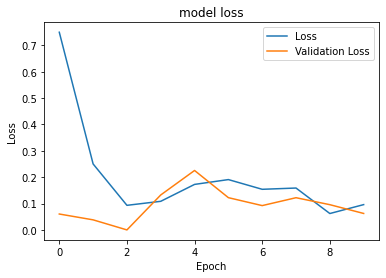

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')


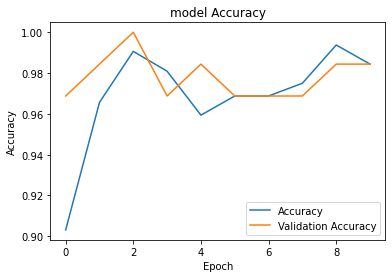

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title("model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()
plt.savefig('chart Accuracy.png')


In [ ]:
for e,i in enumerate(os.listdir('/content/masks/labels/val/')):
  img_number = i.split('.')[0]
  print(i)
  image = img_number+'.jpeg'
  ano = img_number+'.txt'
  with open(os.path.join('/content/masks/labels/val/',ano)) as fp:
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        items = line.split(" ")
        label = int(items[0])
        x1 = int(items[1])
        y1 = int(items[2])
        x2 = int(items[3])
        y2 = int(items[4])
        gtval = {"x1":x1,"x2":x2,"y1":y1,"y2":y2}
  img = cv2.imread(os.path.join('/content/masks/images/val/',image))
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()
  imout = img.copy()
  for e,result in enumerate(ssresults):
      if e < 500:
          x,y,w,h = result
          timage = imout[y:y+h,x:x+w]
          resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
          img = np.expand_dims(resized, axis=0)
          out= model_final.predict(img)
          if out[0][0] > 0.65:
              cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
              iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
              print("iou = ", iou)

  plt.figure()
  plt.imshow(imout)

Output hidden; open in https://colab.research.google.com to view.

## Calculate evaluation matrix
-	The definition of FN, TP and FP are shown below.
-	True Positive (TP): IOU ≥0.5
-	False Positive (FP): IOU <0.5
-	False Negative (FN): When a ground truth (real face) is present in the image and model failed to detect the object

### Manually count for FN, TP, FN
  64 FN,
  18 FN,
  6 FN,
  39 FN,
  10 TP,
  63 FN,
  78 FN,
  60 TP,
  15 TP,
  82 FP,
  75 FN,
  58 FN,
  7 FN,
  5 FN,
  77 FP,
  16 TP,
  37 FN,
  71 TP,
  22 TP,
  0 TP,
  13 FN,
  45 TP,
  40 FN,
  62 FN,
  46 FN,
  68 FP

  Count all: 
  - 15 FN
  - 8 TP
  - 2 FP


**presicion**= TP/(TP+FP) = 80%

**recall** = TP/(TP+FN) = 34.8%